<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
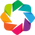

/srv/conda/envs/notebook/lib/python3.11/site-packages/pystac_client/item_search.py:841: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(


In [110]:
import numpy as np
import xarray
import contextily
import geopandas
import stackstac
import pystac_client
import planetary_computer

import xrspatial.multispectral as ms

from dask_gateway import GatewayCluster

import holoviews as hv
hv.extension('bokeh')

# Abrimos el catálogo STAC de Planetary Computer
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# Definimos el bounding box aproximado para el embalse de Chuza
# [lon_min, lat_min, lon_max, lat_max]
bbox =[-73.710, 4.600, -73.695, 4.615] 

# Realizamos la búsqueda en la colección de Sentinel-2 L2A
search = catalog.search(
    collections=["sentinel-2-l2a"],
    bbox=bbox,
    datetime="2015-01-01/2025-01-01",
    query={"eo:cloud_cover": {"lt": 10}}
)

# Getting the metadata
items = list(search.get_all_items())


In [87]:
print(len(items))

19


In [114]:
planetary_computer.__version__

'0.5.1'

In [115]:
import pydantic

pydantic.__version__

'1.10.9'

In [112]:
data = (
    stackstac.stack(
        items,
        assets=["B03", "B08"],  # red, green, blue
        chunksize=4096,
        resolution=100,
    )
    .where(lambda x: x > 0, other=np.nan)  # sentinel-2 uses 0 as nodata
    .assign_coords(band=lambda x: x.common_name.rename("band"))  # use common names
)
data

/srv/conda/envs/notebook/lib/python3.11/site-packages/stackstac/prepare.py:363: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


<xarray.DataArray 'stackstac-0dd1f496214cabf785075b30e8ae48b6' (time: 19,
                                                                band: 2,
                                                                y: 1098, x: 1098)>
dask.array<where, shape=(19, 2, 1098, 1098), dtype=float64, chunksize=(1, 1, 1098, 1098), chunktype=numpy.ndarray>
Coordinates: (12/46)
  * time                                     (time) datetime64[ns] 2016-01-10...
    id                                       (time) <U54 'S2A_MSIL2A_20160110...
  * band                                     (band) <U5 'green' 'nir'
  * x                                        (x) float64 6e+05 ... 7.097e+05
  * y                                        (y) float64 6e+05 ... 4.903e+05
    s2:datastrip_id                          (time) <U64 'S2A_OPER_MSI_L2A_DS...
    ...                                       ...
    proj:bbox                                object {600000.0, 709800.0, 4902...
    proj:transform                           object {0.0, 10.0, -10.0, 600000.0}
    common_name                              (band) <U5 'green' 'nir'
    center_wavelength                        (band) float64 0.56 0.842
    full_width_half_max                      (band) float64 0.045 0.145
    epsg                                     int64 32618
Attributes:
    spec:        RasterSpec(epsg=32618, bounds=(600000, 490200, 709800, 60000...
    crs:         epsg:32618
    transform:   | 100.00, 0.00, 600000.00|\n| 0.00,-100.00, 600000.00|\n| 0....
    resolution:  100

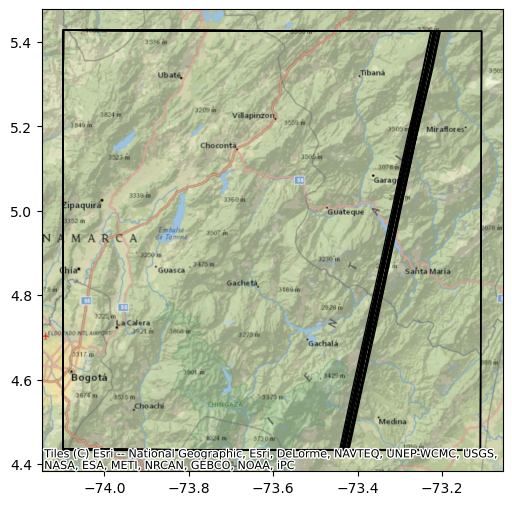

In [97]:
search = catalog.search(
    collections=["sentinel-2-l2a"],
    bbox=bbox,
    datetime="2015-01-01/2025-01-01",
    query={"eo:cloud_cover": {"lt": 10}}
)

items = search.item_collection()

df = geopandas.GeoDataFrame.from_features(items.to_dict(), crs="epsg:4326")

ax = df[["geometry", "datetime", "s2:mgrs_tile", "eo:cloud_cover"]].plot(
    facecolor="none", figsize=(12, 6)
)
contextily.add_basemap(
    ax, crs=df.crs.to_string(), source=contextily.providers.Esri.NatGeoWorldMap
);

In [98]:
green = data.sel(band="green")
nir = data.sel(band="nir")

ndwi = (green - nir) / (green + nir)


In [81]:
import hvplot.xarray  # esto registra el método .hvplot()

# Suponiendo que ndwi es un DataArray de dimensiones: (time, y, x)
ndwi.hvplot(
    x='x',
    y='y',
    groupby='time',  # esto habilita el slider por fecha
    cmap='BrBG',
    clim=(-1, 1),
    frame_width=500,
    frame_height=400,
    title='NDWI dinámico por fecha'
)

KeyboardInterrupt: 

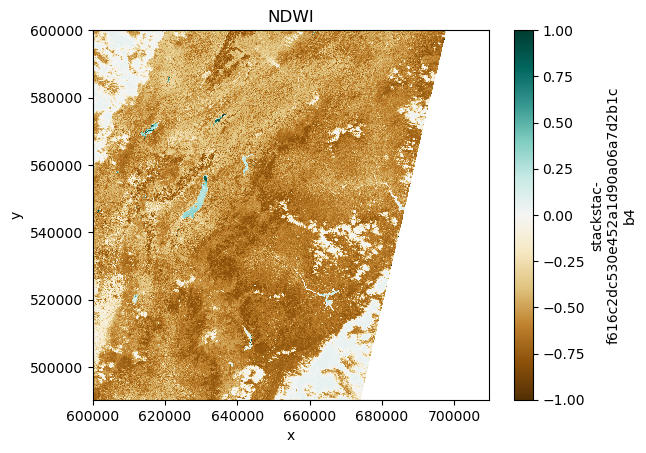

In [104]:
import matplotlib.pyplot as plt

ndwi.sel(time=ndwi.time[2]).plot(cmap="BrBG", vmin=-1, vmax=1)
plt.title("NDWI")
plt.show()


In [99]:
import geopandas as gpd
import shapely.geometry
import rioxarray
import numpy as np
from rasterio.features import geometry_mask

# 1. Crear polígono
polygon = shapely.geometry.Polygon([
    (-73.782570942059508, 4.646643266714992),
    (-73.673135584114817, 4.647268939510189),
    (-73.675646529230207, 4.554246194913797),
    (-73.782989432912061, 4.555080533452189),
    (-73.782570942059508, 4.646643266714992),
])

# 2. Crear GeoDataFrame y asegurar CRS (WGS84, lat/lon)
gdf = gpd.GeoDataFrame({"geometry": [polygon]}, crs="EPSG:4326")

# 3. Reproyectar al CRS de NDWI si es necesario
if ndwi.rio.crs is None:
    ndwi.rio.write_crs("EPSG:4326", inplace=True)

gdf_proj = gdf.to_crs(ndwi.rio.crs)

# 4. Rasterizar la máscara del polígono al shape de NDWI
mask = geometry_mask(
    geometries=gdf_proj.geometry,
    out_shape=(ndwi.sizes['y'], ndwi.sizes['x']),
    transform=ndwi.rio.transform(),
    invert=True
)

# 5. Aplicar la máscara al NDWI
ndwi_masked = ndwi.where(mask)


In [101]:
ndwi_masked

<xarray.DataArray 'stackstac-f616c2dc530e452a1d90a06a7d2b1cb4' (time: 19,
                                                                y: 1098, x: 1098)>
dask.array<where, shape=(19, 1098, 1098), dtype=float64, chunksize=(1, 1098, 1098), chunktype=numpy.ndarray>
Coordinates: (12/42)
  * time                                     (time) datetime64[ns] 2016-01-10...
    id                                       (time) <U54 'S2A_MSIL2A_20160110...
  * x                                        (x) float64 6e+05 ... 7.097e+05
  * y                                        (y) float64 6e+05 ... 4.903e+05
    s2:datastrip_id                          (time) <U64 'S2A_OPER_MSI_L2A_DS...
    s2:dark_features_percentage              (time) float64 1.176 ... 0.541
    ...                                       ...
    proj:shape                               object {10980}
    gsd                                      float64 10.0
    proj:bbox                                object {600000.0, 709800.0, 4902...
    proj:transform                           object {0.0, 10.0, -10.0, 600000.0}
    epsg                                     int64 32618
    spatial_ref                              int64 0

In [107]:
print("CRS NDWI:", ndwi.rio.crs)
print("CRS GDF:", gdf.crs)
print("CRS reproyectado:", gdf_proj.crs)


CRS NDWI: EPSG:4326
CRS GDF: EPSG:4326
CRS reproyectado: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]


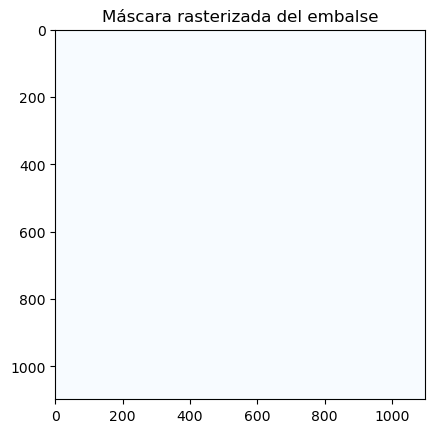

In [109]:
plt.imshow(mask, cmap="Blues")
plt.title("Máscara rasterizada del embalse")
plt.show()


In [105]:
ndwi_masked.sel(time=ndwi_masked.time[2]).plot(cmap="BrBG", vmin=-1, vmax=1)
plt.title("NDWI")
plt.show()

KeyboardInterrupt: 

In [92]:
pixel_counts = []
dates = []

for t in ndwi.time.values:
    try:
        ndwi_t = ndwi.sel(time=t).compute()
        water_mask = ndwi_t > 0.3
        count = water_mask.sum().item()  # total de pixeles de agua
        print(count)
        #pixel_counts.append(count)
        #dates.append(t)
    except Exception as e:
        print(f"Error con fecha {t}: {e}")
        continue


6006
1754
2206
3927
5054
5360
3227
3976
5404
3258
5128
0
11
0
0
11
11
0
0


In [82]:
import numpy as np

pixel_counts = []
dates = []

for t in ndwi.time.values:
    try:
        ndwi_t = ndwi.sel(time=t).compute()
        water_mask = ndwi_t > 0.3
        count = water_mask.sum().item()  # total de pixeles de agua
        pixel_counts.append(count)
        dates.append(t)
    except Exception as e:
        print(f"Error con fecha {t}: {e}")
        continue

import pandas as pd
import matplotlib.pyplot as plt

dates = pd.to_datetime(dates)
years = dates.year

plt.figure(figsize=(10, 5))
plt.plot(years, pixel_counts, marker='o')
plt.xlabel("Año")
plt.ylabel("Número de píxeles de agua")
plt.title("Evolución anual de área de agua (NDWI > 0.3)")
plt.grid()
plt.show()



KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Primero computamos para obtener los valores concretos
counts = water_pixel_counts.compute()

# Extraemos los años de la coordenada time
years = pd.to_datetime(counts.time.values).year

# Graficamos
plt.figure(figsize=(10, 5))
plt.plot(years, counts.values, marker='o', linestyle='-')
plt.xlabel('Año')
plt.ylabel('Número de píxeles clasificados como agua')
plt.title('Evolución anual del área de agua (pixeles NDWI > 0.3)')
plt.grid(True)
plt.show()


In [56]:
import folium

# Coordenadas del centro del bbox
center_lat = (4.5980 + 4.6160) / 2
center_lon = (-73.7105 + -73.6985) / 2

# Crear el mapa centrado en el embalse
m = folium.Map(location=[center_lat, center_lon], zoom_start=14, tiles="CartoDB Positron")

# Añadir el bbox como un rectángulo al mapa
bbox = [ -73.782570942059508, 4.646643266714992 ], [ -73.673135584114817, 4.647268939510189 ], [ -73.675646529230207, 4.554246194913797 ], [ -73.782989432912061, 4.555080533452189 ], [ -73.782570942059508, 4.646643266714992 ]
folium.Rectangle(
    bounds=[[bbox[1], bbox[0]], [bbox[3], bbox[2]]],
    color="blue",
    fill=True,
    fill_opacity=0.2,
    tooltip="Embalse del Chuza"
).add_to(m)

# Mostrar el mapa
m
